<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S11/EVA4_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##Add Google Drive path to system path

In [3]:
os.chdir('./drive/My Drive/colab_notebooks/S11/')

!ls

albumentation_transforms.py  EVA4_S11.ipynb	   triangular_plot.ipynb
config.py		     models		   utils
engine			     train_test_loader.py  visualization


##Import python files

In [4]:
import train_test_loader as ttl
import config as cfg
from models import BaseModel as bm
from torch.optim.lr_scheduler import OneCycleLR
from engine import LRFinder
from visualization import visualise_acc as vis
import utils.gradcam as gc
import utils.get_images as gc_img

##Main Function

In [9]:
def main(args=cfg.Config()):
    train_loader, test_loader, test_transform = ttl.get_train_test(args)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = bm.Net().to(device)
    summary(model, input_size=(3, 32, 32))

    optimizer = optim.SGD(model.parameters(), lr=args.start_lr, momentum=args.momentum, dampening=0,weight_decay=args.weight_decay, nesterov=False)
    criterion = nn.CrossEntropyLoss()

    # LR Range Test
    num_iterations = 10 * len(train_loader)
    lr_finder = LRFinder(model, optimizer, criterion, metric='accuracy', device=device)
    print('\n--Range Test--')
    lr_finder.range_test(train_loader, num_iterations, mode='iteration', end_lr=args.end_lr, step_mode='linear',diverge_th=0)

    # Get best initial learning rate
    initial_lr = lr_finder.best_lr
    lr_finder.plot()
    lr_finder.reset()

    # Define one cycle policy
    one_cycle_policy = OneCycleLR(optimizer, initial_lr, epochs=args.epochs, steps_per_epoch=len(train_loader),pct_start=args.max_at_epoch / args.epochs, div_factor=10, final_div_factor=1)

    # Train and Test model
    model.fit(train_loader, optimizer, criterion, device=device, epochs=args.epochs, val_loader=test_loader,callbacks=[one_cycle_policy])

    vis.plot_acc(test_accuracy=model.learner.val_accuracies, train_accuracy=model.learner.train_accuracies)

    misclass = gc_img.get_images(model, device, test_loader, batch_size=args.batch_size, num_imgs=8)
    target_layers = ["layer1", "layer2", "layer3"]
    viz_cam = gc.VisualizeCam(model, args.classes, target_layers)

    incorrect_pred_imgs = []
    inc_image_for_gradcam = []
    for i in range(len(misclass)):
        incorrect_pred_imgs.append(torch.as_tensor(misclass[i][0]))
        inc_image_for_gradcam.append(misclass[i])

    print('\n--GRADCAM FOR MISCLASSIFIED IMAGES--')
    viz_cam(torch.stack(incorrect_pred_imgs), inc_image_for_gradcam, target_layers, metric="incorrect")


CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
      

lr=0.02002040714285714 Iteration=979 accuracy=67.03:   0%|          | 0/98 [16:41<?, ?it/s]

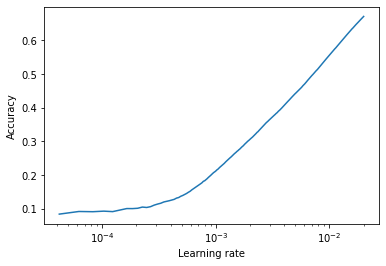

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1:


lr=0.02002040714285714 Iteration=979 accuracy=67.03:   0%|          | 0/98 [16:47<?, ?it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5345/10000 (53.45%)

Epoch 2:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6201/10000 (62.01%)

Epoch 3:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6890/10000 (68.90%)

Epoch 4:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7383/10000 (73.83%)

Epoch 5:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7827/10000 (78.27%)

Epoch 6:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7848/10000 (78.48%)

Epoch 7:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8252/10000 (82.52%)

Epoch 8:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7837/10000 (78.37%)

Epoch 9:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8516/10000 (85.16%)

Epoch 10:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8201/10000 (82.01%)

Epoch 11:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8232/10000 (82.32%)

Epoch 12:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8181/10000 (81.81%)

Epoch 13:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8582/10000 (85.82%)

Epoch 14:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8400/10000 (84.00%)

Epoch 15:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8568/10000 (85.68%)

Epoch 16:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8653/10000 (86.53%)

Epoch 17:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8751/10000 (87.51%)

Epoch 18:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8781/10000 (87.81%)

Epoch 19:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8854/10000 (88.54%)

Epoch 20:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9011/10000 (90.11%)

Epoch 21:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9073/10000 (90.73%)

Epoch 22:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9042/10000 (90.42%)

Epoch 23:


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9164/10000 (91.64%)

Epoch 24:


Loss=0.2121 Batch_id=97 Accuracy=82.46: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]



Test set: Average loss: 0.0006, Accuracy: 9114/10000 (91.14%)


--GRADCAM FOR MISCLASSIFIED IMAGES--


lr=0.00044995714285714285 Iteration=20 accuracy=13.14:   0%|          | 0/98 [1:01:38<?, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


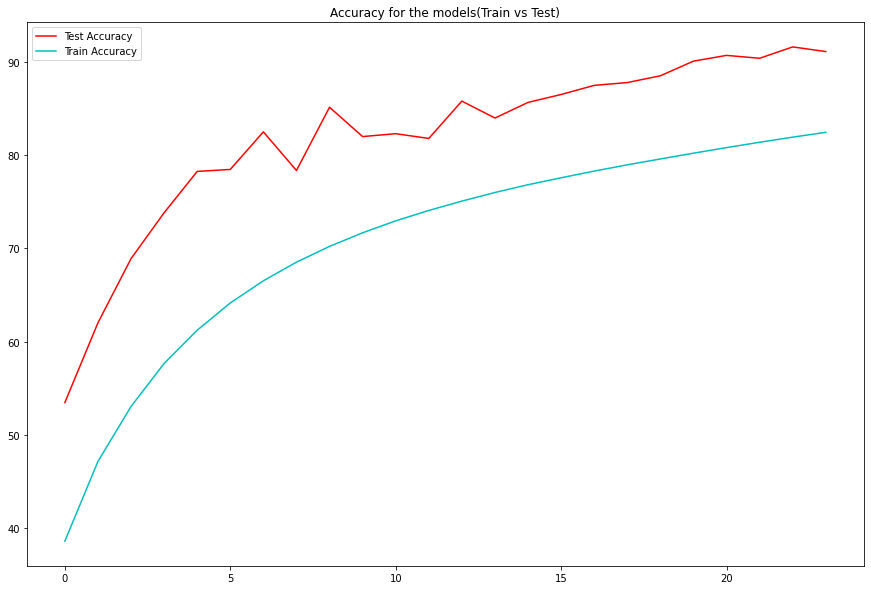

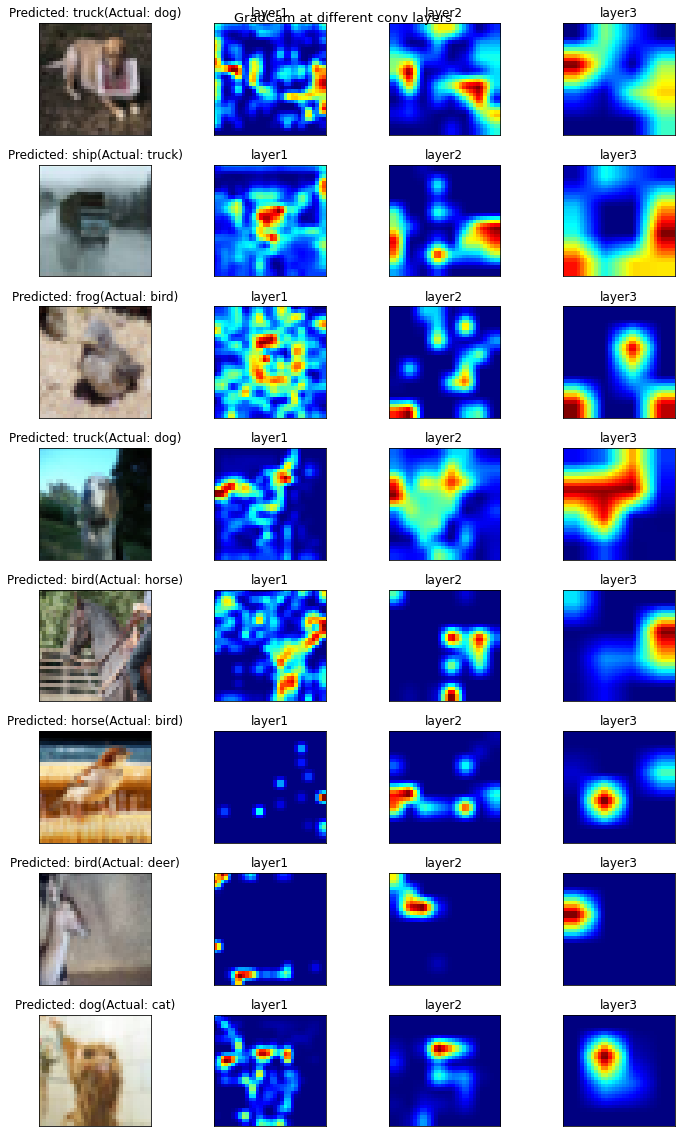

In [10]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()
  main()